# Import Libraries

In [1]:
import os, cv2, re, random  #cv2 for OpenCV
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import RMSprop, adam
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from matplotlib.image import imread

os.chdir('C:\\Users\\Min Xie i7\\Desktop\\Northwestern University\\Practical Machine Learning\\week7')

Using TensorFlow backend.


# Plot Several Cat and Dog Photos From Dataset

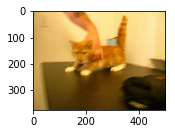

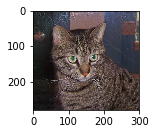

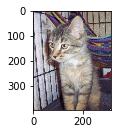

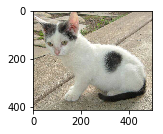

In [2]:
# define location of dataset
folder = 'input\\train\\'

# plot first few cat images
for i in range(4):
    pyplot.subplot(220 +1 +i) 
    filename = folder + 'cat.' + str(i) + '.jpg'   # define filename
    image = imread(filename)  # load image pixels
    pyplot.imshow(image)   # plot raw pixel data
    pyplot.show()  # show the figure

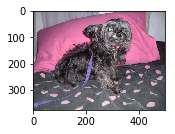

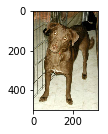

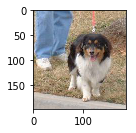

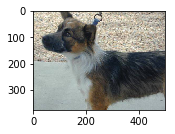

In [3]:
# plot first few dog images
for i in range(4):
    pyplot.subplot(220 +1 +i) 
    filename = folder + 'dog.' + str(i) + '.jpg'   # define filename
    image = imread(filename)  # load image pixels
    pyplot.imshow(image)   # plot raw pixel data
    pyplot.show()  # show the figure

# Set Data Dimensions and Paths

In [4]:
img_width = 150
img_height = 150

TRAIN_DIR = 'input\\train\\'
train_images_dogs_cats = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # get a full list of the file names in 'train' folder

TEST_DIR = 'input\\test\\'
test_images_dogs_cats = [TEST_DIR+i for i in os.listdir(TEST_DIR)]  #get a full list of the file names in 'test' folder

In [5]:
train_images_dogs_cats

['input\\train\\cat.0.jpg',
 'input\\train\\cat.1.jpg',
 'input\\train\\cat.10.jpg',
 'input\\train\\cat.100.jpg',
 'input\\train\\cat.1000.jpg',
 'input\\train\\cat.10000.jpg',
 'input\\train\\cat.10001.jpg',
 'input\\train\\cat.10002.jpg',
 'input\\train\\cat.10003.jpg',
 'input\\train\\cat.10004.jpg',
 'input\\train\\cat.10005.jpg',
 'input\\train\\cat.10006.jpg',
 'input\\train\\cat.10007.jpg',
 'input\\train\\cat.10008.jpg',
 'input\\train\\cat.10009.jpg',
 'input\\train\\cat.1001.jpg',
 'input\\train\\cat.10010.jpg',
 'input\\train\\cat.10011.jpg',
 'input\\train\\cat.10012.jpg',
 'input\\train\\cat.10013.jpg',
 'input\\train\\cat.10014.jpg',
 'input\\train\\cat.10015.jpg',
 'input\\train\\cat.10016.jpg',
 'input\\train\\cat.10017.jpg',
 'input\\train\\cat.10018.jpg',
 'input\\train\\cat.10019.jpg',
 'input\\train\\cat.1002.jpg',
 'input\\train\\cat.10020.jpg',
 'input\\train\\cat.10021.jpg',
 'input\\train\\cat.10022.jpg',
 'input\\train\\cat.10023.jpg',
 'input\\train\\cat.1002

# Sort Files Based on Numeric Value in Each File Name

In [6]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

In [7]:
# Sort the traning set
# Use 1000 images each of cats and dogs instead of all 25,000 to speed up the learning process
train_images_dogs_cats.sort(key=natural_keys)
train_images_dogs_cats = train_images_dogs_cats[0:1000] + train_images_dogs_cats[12500:13500] 

# Sort the test set
test_images_dogs_cats.sort(key=natural_keys)

In [8]:
# check the train and test data sets
print(len(train_images_dogs_cats), len(test_images_dogs_cats))

2000 12500


# Set Labels for Supervised Learning

In [9]:
def prepare_data(list_of_images):  #define the helper function
    x = [] # an array of resized images
    y = [] # an array of labels - 0 for cat and 1 for dog
    
    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(image), (img_width,img_height), interpolation=cv2.INTER_CUBIC))
    
    for i in list_of_images:
        if 'dog' in i:
            y.append(1)
        elif 'cat' in i:
            y.append(0)
            
    return x, y

In [10]:
X, Y = prepare_data(train_images_dogs_cats)   #images are represented by numbers using the helper function

print(K.image_data_format())  #check the default image data format convention. For tensorflow backend, it is “channels_last”. 

channels_last


In [11]:
#Split the raw training data into training set and validation set

X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=1)

In [12]:
nb_train_samples = len(X_train)    #1600
nb_validation_samples = len(X_val)  #400
batch_size = 16

In [13]:
print(nb_train_samples, nb_validation_samples)

1600 400


# Image Augmentation

In [18]:
# create data generator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# prepare iterators
train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size, shuffle=True)

validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size, shuffle=True)

# One Block VGG Model

In [24]:
# one-block VGG model has a single convolutional layer with 32 filters followed by a max pooling layer.
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_width, img_height, 3)))
model1.add(layers.MaxPooling2D(pool_size=(2, 2)))
model1.add(layers.BatchNormalization())   #add normalization layer
model1.add(Flatten())
model1.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))  #use 'sigmoid' for binary classification

# compile model
model1.compile(loss='binary_crossentropy',
              optimizer=adam(lr=1e-5),   #reduce the learning rate
              metrics=['accuracy'])

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
flatten_6 (Flatten)          (None, 180000)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               23040128  
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total para

In [25]:
#fit the model
history1 = model1.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/15
100/100 [==============================] - 78s 776ms/step - loss: 0.9100 - acc: 0.5481 - val_loss: 0.6929 - val_acc: 0.6125
Epoch 2/15
100/100 [==============================] - 75s 750ms/step - loss: 0.7460 - acc: 0.6144 - val_loss: 0.6463 - val_acc: 0.6475
Epoch 3/15
100/100 [==============================] - 75s 749ms/step - loss: 0.7126 - acc: 0.6219 - val_loss: 0.6401 - val_acc: 0.6625
Epoch 4/15
100/100 [==============================] - 75s 746ms/step - loss: 0.6405 - acc: 0.6700 - val_loss: 0.6598 - val_acc: 0.6700
Epoch 5/15
100/100 [==============================] - 74s 741ms/step - loss: 0.6234 - acc: 0.7006 - val_loss: 0.6371 - val_acc: 0.6775
Epoch 6/15
100/100 [==============================] - 81s 808ms/step - loss: 0.6034 - acc: 0.7013 - val_loss: 0.6745 - val_acc: 0.6725
Epoch 7/15
100/100 [==============================] - 77s 773ms/step - loss: 0.5764 - acc: 0.7081 - val_loss: 0.6602 - val_acc: 0.6700
Epoch 8/15
100/100 [==============================] - 7

In [26]:
# evaluate model
_, acc = model1.evaluate_generator(validation_generator, steps=len(validation_generator), verbose=2)
print('> %.2f' % (acc * 100.0))

# Table of the training/validation loss/accuracy
pd.DataFrame(history1.history)

> 69.75


,val_loss,val_acc,loss,acc
0,0.692869,0.6125,0.909979,0.548125
1,0.646286,0.6475,0.745960,0.614375
2,0.640126,0.6625,0.712598,0.621875
3,0.659784,0.6700,0.640513,0.670000
4,0.637094,0.6775,0.623396,0.700625
5,0.674466,0.6725,0.603390,0.701250
6,0.660202,0.6700,0.576387,0.708125
7,0.618877,0.7000,0.577173,0.701250
8,0.625177,0.6600,0.564244,0.691250
9,0.606845,0.7050,0.548081,0.731250


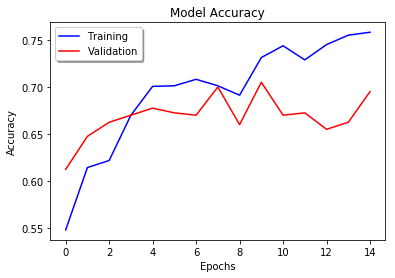

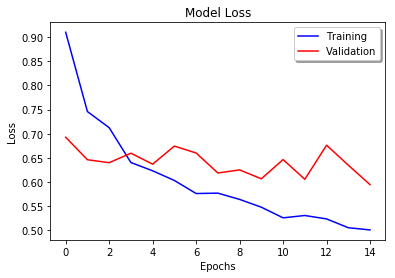

In [27]:
# Plot the accuracy curves for training and validation 
pyplot.plot(history1.history['acc'], color='b', label="Training")
pyplot.plot(history1.history['val_acc'], color='r',label="Validation")
pyplot.title("Model Accuracy")
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epochs')
pyplot.legend(loc='best', shadow=True)
pyplot.show() 

# Plot the loss curves for training and validation 
pyplot.plot(history1.history['loss'], color='b', label="Training")
pyplot.plot(history1.history['val_loss'], color='r',label="Validation")
pyplot.title("Model Loss")
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend(loc='best', shadow=True)
pyplot.show() 

In [29]:
# Predict Classification on Test Data

X_test, Y_test = prepare_data(test_images_dogs_cats) #images are represented by numbers, Y_test in this case will be []

test_datagen = ImageDataGenerator(rescale=1. / 255)  #augmentation configuration
test_generator = val_datagen.flow(np.array(X_test), batch_size=batch_size, shuffle=True)

#get the preditions on test data
predictions = model1.predict_generator(test_generator, steps=len(test_generator), verbose=1)

782/782 [==============================] - 131s 168ms/step


In [30]:
#create Kaggle submission file
solution = pd.DataFrame({"id": range(1, len(test_images_dogs_cats) + 1), 
                         "label":list(predictions)})

cols = ['label']
for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)  #remove '[' and ']' for label

solution.to_csv("Dogs_vs_Cats submission1.csv", index = False, header=True)

# Two Block VGG Model

In [31]:
# two-block VGG model extends the one block model and adds a second block with 64 filters.
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_width, img_height, 3)))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.BatchNormalization())   #add normalization layer
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))  #use 'sigmoid' for binary classification

# compile model
model2.compile(loss='binary_crossentropy',
              optimizer=adam(lr=1e-5),
              metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 37, 37, 64)        256       
_________________________________________________________________
flatten_7 (Flatten)          (None, 87616)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               11214976  
__________

In [32]:
#fit the model
history2 = model2.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/15
100/100 [==============================] - 75s 754ms/step - loss: 0.7991 - acc: 0.5956 - val_loss: 0.7178 - val_acc: 0.5950
Epoch 2/15
100/100 [==============================] - 73s 731ms/step - loss: 0.7301 - acc: 0.6344 - val_loss: 0.6294 - val_acc: 0.6975
Epoch 3/15
100/100 [==============================] - 72s 719ms/step - loss: 0.6641 - acc: 0.6575 - val_loss: 0.6202 - val_acc: 0.6850
Epoch 4/15
100/100 [==============================] - 72s 725ms/step - loss: 0.6112 - acc: 0.6863 - val_loss: 0.5791 - val_acc: 0.7025
Epoch 5/15
100/100 [==============================] - 81s 813ms/step - loss: 0.5844 - acc: 0.6931 - val_loss: 0.5808 - val_acc: 0.7175
Epoch 6/15
100/100 [==============================] - 75s 747ms/step - loss: 0.5702 - acc: 0.7156 - val_loss: 0.5736 - val_acc: 0.7175
Epoch 7/15
100/100 [==============================] - 72s 716ms/step - loss: 0.5473 - acc: 0.7231 - val_loss: 0.5939 - val_acc: 0.6900
Epoch 8/15
100/100 [==============================] - 7

In [33]:
# evaluate model
_, acc = model2.evaluate_generator(validation_generator, steps=len(validation_generator), verbose=2)
print('> %.2f' % (acc * 100.0))

# Table of the training/validation loss/accuracy
pd.DataFrame(history2.history)

> 74.50


,val_loss,val_acc,loss,acc
0,0.717817,0.5950,0.799059,0.595625
1,0.629353,0.6975,0.730101,0.634375
2,0.620240,0.6850,0.664144,0.657500
3,0.579071,0.7025,0.611199,0.686250
4,0.580835,0.7175,0.584355,0.693125
5,0.573636,0.7175,0.570236,0.715625
6,0.593925,0.6900,0.547303,0.723125
7,0.526936,0.7175,0.533983,0.733750
8,0.512806,0.7575,0.519592,0.746250
9,0.598218,0.7025,0.490773,0.764375


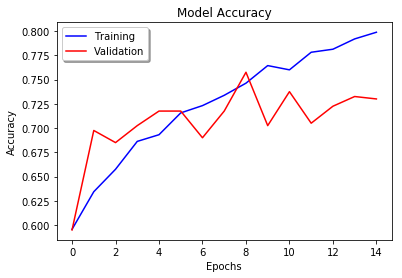

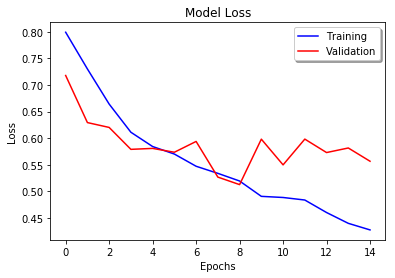

In [34]:
# Plot the accuracy curves for training and validation 
pyplot.plot(history2.history['acc'], color='b', label="Training")
pyplot.plot(history2.history['val_acc'], color='r',label="Validation")
pyplot.title("Model Accuracy")
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epochs')
pyplot.legend(loc='best', shadow=True)
pyplot.show() 

# Plot the loss curves for training and validation 
pyplot.plot(history2.history['loss'], color='b', label="Training")
pyplot.plot(history2.history['val_loss'], color='r',label="Validation")
pyplot.title("Model Loss")
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend(loc='best', shadow=True)
pyplot.show() 

In [35]:
# Predict Classification on Test Data
predictions2 = model2.predict_generator(test_generator, steps=len(test_generator), verbose=1)

#create Kaggle submission file
solution = pd.DataFrame({"id": range(1, len(test_images_dogs_cats) + 1), 
                         "label":list(predictions2)})

cols = ['label']
for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)  #remove '[' and ']' for label

solution.to_csv("Dogs_vs_Cats submission2.csv", index = False, header=True)

782/782 [==============================] - 146s 187ms/step


# Three Block VGG Model

In [37]:
# three-block VGG model extends the two block model and adds a third block with 128 filters
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_width, img_height, 3)))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.BatchNormalization())   #add normalization layer
model3.add(Flatten())
model3.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))  #use 'sigmoid' for binary classification

# compile model
model3.compile(loss='binary_crossentropy',
              optimizer=adam(lr=1e-5),
              metrics=['accuracy'])

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 18, 18, 64)        256       
__________

In [38]:
#fit the model
history3 = model3.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/15
100/100 [==============================] - 68s 677ms/step - loss: 0.8697 - acc: 0.5175 - val_loss: 0.7100 - val_acc: 0.5450
Epoch 2/15
100/100 [==============================] - 63s 630ms/step - loss: 0.7864 - acc: 0.5450 - val_loss: 0.6505 - val_acc: 0.6400
Epoch 3/15
100/100 [==============================] - 61s 609ms/step - loss: 0.6916 - acc: 0.6106 - val_loss: 0.6423 - val_acc: 0.6575
Epoch 4/15
100/100 [==============================] - 61s 613ms/step - loss: 0.6903 - acc: 0.6144 - val_loss: 0.6496 - val_acc: 0.6550
Epoch 5/15
100/100 [==============================] - 61s 613ms/step - loss: 0.6796 - acc: 0.6188 - val_loss: 0.6538 - val_acc: 0.6250
Epoch 6/15
100/100 [==============================] - 61s 612ms/step - loss: 0.6326 - acc: 0.6544 - val_loss: 0.6444 - val_acc: 0.6525
Epoch 7/15
100/100 [==============================] - 62s 621ms/step - loss: 0.6232 - acc: 0.6663 - val_loss: 0.6306 - val_acc: 0.6600
Epoch 8/15
100/100 [==============================] - 6

In [39]:
# evaluate model
_, acc = model3.evaluate_generator(validation_generator, steps=len(validation_generator), verbose=2)
print('> %.2f' % (acc * 100.0))

# Table of the training/validation loss/accuracy
pd.DataFrame(history3.history)

> 67.00


,val_loss,val_acc,loss,acc
0,0.710022,0.5450,0.869683,0.517500
1,0.650500,0.6400,0.786364,0.545000
2,0.642277,0.6575,0.691623,0.610625
3,0.649565,0.6550,0.690264,0.614375
4,0.653763,0.6250,0.679580,0.618750
5,0.644382,0.6525,0.632635,0.654375
6,0.630584,0.6600,0.623202,0.666250
7,0.635743,0.6775,0.617111,0.660000
8,0.599902,0.6875,0.605774,0.693125
9,0.632037,0.6275,0.597805,0.700000


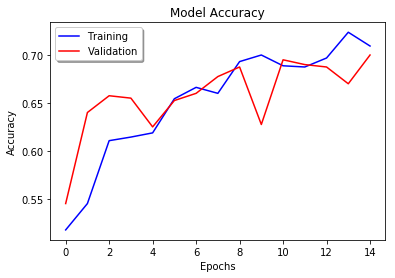

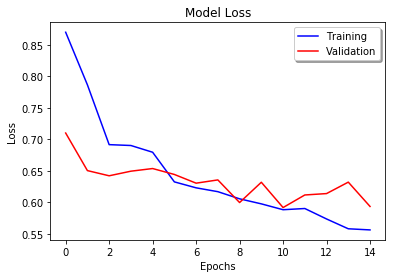

In [40]:
# Plot the accuracy curves for training and validation 
pyplot.plot(history3.history['acc'], color='b', label="Training")
pyplot.plot(history3.history['val_acc'], color='r',label="Validation")
pyplot.title("Model Accuracy")
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epochs')
pyplot.legend(loc='best', shadow=True)
pyplot.show() 

# Plot the loss curves for training and validation 
pyplot.plot(history3.history['loss'], color='b', label="Training")
pyplot.plot(history3.history['val_loss'], color='r',label="Validation")
pyplot.title("Model Loss")
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend(loc='best', shadow=True)
pyplot.show() 

In [41]:
# Predict Classification on Test Data
predictions3 = model3.predict_generator(test_generator, steps=len(test_generator), verbose=1)

#create Kaggle submission file
solution = pd.DataFrame({"id": range(1, len(test_images_dogs_cats) + 1), 
                         "label":list(predictions3)})

cols = ['label']
for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)  #remove '[' and ']' for label

solution.to_csv("Dogs_vs_Cats submission3.csv", index = False, header=True)

782/782 [==============================] - 154s 197ms/step


# Two Block VGG with Model Improvements

In [46]:
# create data generator
# change te zoom range from 0.2 to 0.1
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

# prepare iterators, change batch_size from 16 to 64
train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size, shuffle=True)  

validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size, shuffle=True)

In [52]:
#a dropout of 20% is applied after each VGG block
#with a larger dropout rate of 50% applied after the fully connected layer 

model4 = Sequential()

model4.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(img_width, img_height, 3)))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.BatchNormalization())   #add normalization layer
model4.add(Dropout(0.2))
model4.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.BatchNormalization())   #add normalization layer
model4.add(Dropout(0.2))
model4.add(Flatten())
model4.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model4.add(Dropout(0.5))
model4.add(Dense(1, activation='sigmoid'))  #use 'sigmoid' for binary classification

# compile model
model4.compile(loss='binary_crossentropy',
              optimizer=adam(lr=1e-5),
              metrics=['accuracy'])

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
dropout_17 (Dropout)         (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 37, 37, 64)        256       
__________

In [53]:
#fit the model
history4 = model4.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Epoch 1/15
100/100 [==============================] - 336s 3s/step - loss: 0.8155 - acc: 0.6019 - val_loss: 0.6213 - val_acc: 0.6619
Epoch 2/15
100/100 [==============================] - 330s 3s/step - loss: 0.6702 - acc: 0.6680 - val_loss: 0.6113 - val_acc: 0.6806
Epoch 3/15
100/100 [==============================] - 329s 3s/step - loss: 0.5859 - acc: 0.7044 - val_loss: 0.5820 - val_acc: 0.7131
Epoch 4/15
100/100 [==============================] - 328s 3s/step - loss: 0.5321 - acc: 0.7423 - val_loss: 0.5725 - val_acc: 0.7136
Epoch 5/15
100/100 [==============================] - 327s 3s/step - loss: 0.4980 - acc: 0.7572 - val_loss: 0.5805 - val_acc: 0.7287
Epoch 6/15
100/100 [==============================] - 333s 3s/step - loss: 0.4657 - acc: 0.7786 - val_loss: 0.5717 - val_acc: 0.7218
Epoch 7/15
100/100 [==============================] - 330s 3s/step - loss: 0.4427 - acc: 0.7903 - val_loss: 0.5680 - val_acc: 0.7280
Epoch 8/15
100/100 [==============================] - 328s 3s/step - 

In [54]:
# evaluate model
_, acc = model4.evaluate_generator(validation_generator, steps=len(validation_generator), verbose=2)
print('> %.2f' % (acc * 100.0))

# Table of the training/validation loss/accuracy
pd.DataFrame(history4.history)

> 68.25


,val_loss,val_acc,loss,acc
0,0.621348,0.661932,0.815489,0.601875
1,0.611330,0.680632,0.670227,0.667969
2,0.581959,0.713068,0.585875,0.704375
3,0.572524,0.713599,0.532101,0.742344
4,0.580525,0.728693,0.498039,0.757188
5,0.571738,0.721841,0.465689,0.778594
6,0.567978,0.727983,0.442657,0.790312
7,0.566721,0.726562,0.418844,0.806875
8,0.579663,0.725275,0.388104,0.821406
9,0.587974,0.716619,0.368540,0.835469


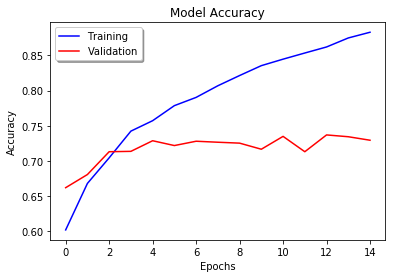

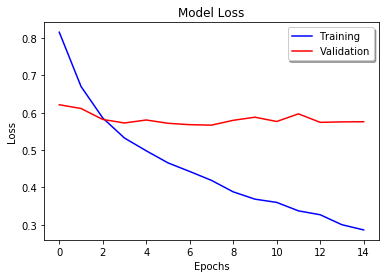

In [55]:
# Plot the accuracy curves for training and validation 
pyplot.plot(history4.history['acc'], color='b', label="Training")
pyplot.plot(history4.history['val_acc'], color='r',label="Validation")
pyplot.title("Model Accuracy")
pyplot.ylabel('Accuracy')
pyplot.xlabel('Epochs')
pyplot.legend(loc='best', shadow=True)
pyplot.show() 

# Plot the loss curves for training and validation 
pyplot.plot(history4.history['loss'], color='b', label="Training")
pyplot.plot(history4.history['val_loss'], color='r',label="Validation")
pyplot.title("Model Loss")
pyplot.ylabel('Loss')
pyplot.xlabel('Epochs')
pyplot.legend(loc='best', shadow=True)
pyplot.show() 

In [56]:
# Predict Classification on Test Data
predictions4 = model4.predict_generator(test_generator, steps=len(test_generator), verbose=1)

#create Kaggle submission file
solution = pd.DataFrame({"id": range(1, len(test_images_dogs_cats) + 1), 
                         "label":list(predictions4)})

cols = ['label']
for col in cols:
    solution[col] = solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)  #remove '[' and ']' for label

solution.to_csv("Dogs_vs_Cats submission5.csv", index = False, header=True)

782/782 [==============================] - 178s 227ms/step


In [64]:
print("\nModel4 - Training Set ", model4.evaluate_generator(train_generator, steps=len(train_generator), verbose=2))
print("\nModel4 - Validation Set ", model4.evaluate_generator(validation_generator, steps=len(validation_generator), verbose=2))


Model4 - Training Set  [0.23253952085971832, 0.920625]

Model4 - Validation Set  [0.6063710713386535, 0.7375]


In [66]:
print("\nModel3 - Training Set", model3.evaluate_generator(train_generator, steps=len(train_generator), verbose=2))
print("\nModel3 - Validation Set",model3.evaluate_generator(validation_generator, steps=len(validation_generator), verbose=2))


Model3 - Training Set [0.4856873869895935, 0.786875]

Model3 - Validation Set [0.5890785384178162, 0.7125]


In [67]:
print("\nModel2 - Training Set", model2.evaluate_generator(train_generator, steps=len(train_generator), verbose=2))
print("\nModel2 - Validation Set",model2.evaluate_generator(validation_generator, steps=len(validation_generator), verbose=2))


Model2 - Training Set [0.32108385264873507, 0.87875]

Model2 - Validation Set [0.5563695573806763, 0.725]


In [68]:
print("\nModel1 - Training Set", model1.evaluate_generator(train_generator, steps=len(train_generator), verbose=2))
print("\nModel1 - Validation Set",model1.evaluate_generator(validation_generator, steps=len(validation_generator), verbose=2))


Model1 - Training Set [0.3827786719799042, 0.83875]

Model1 - Validation Set [0.5895940446853638, 0.74]
